In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.2


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [3]:
# Build the model

class MyModel(Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)
        self.dropout = Dropout(0.4)

    def call(self, inputs, training=True):
        x = self.dense_1(inputs)

        if training:
            x = self.dropout(x)
            
        return self.dense_2(x)


In [4]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1, 10]))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  704       
                                                                 
 dense_1 (Dense)             multiple                  650       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


In [5]:
class MyModel(Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64)
        self.dense_2 = Dense(10)
        self.dense_3 = Dense(5)
        self.softmax = Softmax()

    def call(self, inputs):
        x = self.dense_1(inputs)
        y1 = self.dense_2(inputs)
        y2 = self.dense_3(y1)
        concat = concatenate([x, y2])

        return self.softmax(concat)


In [6]:
model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             multiple                  704       
                                                                 
 dense_3 (Dense)             multiple                  110       
                                                                 
 dense_4 (Dense)             multiple                  55        
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [8]:
# Create a custom layer

class MyLayer(Layer):

    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
        self.b = self.add_weight(shape=(units,), initializer='zeros')


    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


dense_layer = MyLayer(3, 5)
x = tf.ones((1, 5))

print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[ 0.17023557 -0.06952328  0.21984395]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.13540995, -0.01776023,  0.04418695],
       [ 0.01764113,  0.11468474, -0.0441861 ],
       [ 0.04134449, -0.08330353,  0.09496459],
       [-0.05472815, -0.08774783,  0.05439732],
       [ 0.03056816,  0.00460357,  0.07048119]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [9]:
# Specify trainable weights

class MyLayer(Layer):

    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal', trainable=False)
        self.b = self.add_weight(shape=(units,), initializer='zeros', trainable=False)


    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


dense_layer = MyLayer(3, 5)

In [10]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [11]:
# Create a custom layer to accumulate means of output values

class MyLayerMean(Layer):

    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal', trainable=False)
        self.b = self.add_weight(shape=(units,), initializer='zeros', trainable=False)
        self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)), trainable=False)
        self.number_call = tf.Variable(initial_value=0, trainable=False)

    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_call.assign_add(inputs.shape[0])
        return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)


dense_layer = MyLayerMean(3, 5)

In [12]:
# Test the layer
# the weights do not change because we are not changing the weights and biases
# this can be useful if we want to analyze the propagation
# of signals in a network
y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[-0.13416645  0.21673462 -0.02175037]
[-0.13416645  0.21673462 -0.02175037]


In [13]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [14]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [15]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.03249924 0.01518492 0.03520592 0.02216888 0.02571679 0.01440755
  0.01969794 0.01210358 0.02236021 0.01625276 0.01886163 0.02548575
  0.02238332 0.01406043 0.01395061 0.02218554 0.01719143 0.02481675
  0.0311988  0.02192876 0.04051666 0.02415468 0.01641873 0.0074969
  0.02222106 0.01114113 0.02923696 0.0318312  0.00748392 0.02235615
  0.08034562 0.01477216 0.03455975 0.01846828 0.01849226 0.02586483
  0.01069667 0.0069191  0.01774755 0.01519515 0.02114782 0.01858312
  0.02923378 0.01488368 0.01054317 0.02202893]], shape=(1, 46), dtype=float32)
Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer_2 (MyLayer)        multiple                  640064    
                                                                 
 my_dropout (MyDropout)      multiple                  0         
                                                                 
 my_layer_3 (MyLaye

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [16]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

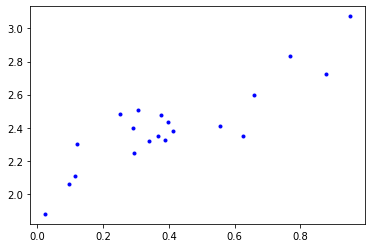

In [17]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [18]:
from tensorflow.keras.layers import Layer

In [19]:
# Build a custom layer for the linear regression model

class LinearRegressionLayer(Layer):

    def __init__(self):
        super(LinearRegressionLayer, self).__init__()
        self.m = self.add_weight(shape=(1,), initializer='random_normal')
        self.b = self.add_weight(shape=(1,), initializer='zeros')


    def call(self, inputs):
        return self.m * inputs + self.b

In [20]:
linear_regression_layer = LinearRegressionLayer()

In [21]:
# for attr in dir(linear_regression_layer):
#     print("obj.%s = %r" % (attr, getattr(linear_regression_layer, attr)))

In [22]:
print(linear_regression_layer(x_train))
print(linear_regression_layer.weights)

tf.Tensor(
[-0.02519771 -0.02198721 -0.02449995 -0.03610049 -0.00622328 -0.05700725
 -0.0015776  -0.01899617 -0.01979944 -0.02670473 -0.01637697 -0.00735377
 -0.06171056 -0.04061648 -0.01888262 -0.02573195 -0.04984999 -0.02377238
 -0.00778639 -0.04284893], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.06491695], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [23]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression_layer(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.030117


#### Train and plot the model

In [24]:
# print the trainable variables used in the calculation of the gradient
print(linear_regression_layer.trainable_variables)

print(linear_regression_layer.m)
print(linear_regression_layer.b)

[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.06491695], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.06491695], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


In [25]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for i in range(steps):

    with tf.GradientTape() as tape:
        predictions = linear_regression_layer(x_train)
        loss = SquaredError(predictions, y_train)

    gradients = tape.gradient(loss, linear_regression_layer.trainable_variables)

    linear_regression_layer.m.assign_sub(learning_rate * gradients[0])
    linear_regression_layer.b.assign_sub(learning_rate * gradients[1])

    print('Step: %d, Loss: %f' % (i, loss))
    

Step: 0, Loss: 6.030117
Step: 1, Loss: 4.696500
Step: 2, Loss: 3.658597
Step: 3, Loss: 2.850836
Step: 4, Loss: 2.222185
Step: 5, Loss: 1.732930
Step: 6, Loss: 1.352161
Step: 7, Loss: 1.055822
Step: 8, Loss: 0.825193
Step: 9, Loss: 0.645702
Step: 10, Loss: 0.506010
Step: 11, Loss: 0.397293
Step: 12, Loss: 0.312682
Step: 13, Loss: 0.246833
Step: 14, Loss: 0.195584
Step: 15, Loss: 0.155698
Step: 16, Loss: 0.124656
Step: 17, Loss: 0.100497
Step: 18, Loss: 0.081694
Step: 19, Loss: 0.067060
Step: 20, Loss: 0.055670
Step: 21, Loss: 0.046806
Step: 22, Loss: 0.039906
Step: 23, Loss: 0.034536
Step: 24, Loss: 0.030357


m:1,  trained m:[0.80312365]
b:2,  trained b:[1.9790715]


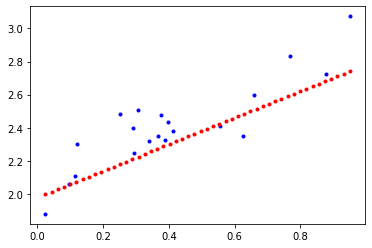

In [26]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression_layer.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression_layer.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression_layer.m*x_linear_regression+linear_regression_layer.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [29]:
# Define the custom layers and model

class MyLayer(Layer):

    def __init__(self, units):
        super(MyLayer, self).__init__()

        self.units = units


    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), 
                                 initializer='random_normal',
                                 name='kernel')
        self.b = self.add_weight(shape=(self.units,), 
                                 initializer='zeros',
                                 name='bias')


    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)



class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)


In [30]:
model = MyModel(64, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.00568503 0.01397724 0.0403087  0.02013211 0.04196637 0.01424354
  0.01819351 0.0164536  0.00842858 0.0136298  0.00683523 0.03333626
  0.03879611 0.00114234 0.00796559 0.07881483 0.00535741 0.0161962
  0.02258131 0.01190623 0.06885441 0.01708183 0.04503251 0.03423188
  0.02035045 0.00076327 0.02712091 0.00781009 0.02693769 0.02007902
  0.01524629 0.0183035  0.01323194 0.0053593  0.01178917 0.03646528
  0.0327453  0.05121071 0.01476681 0.01424032 0.03572819 0.00991455
  0.01121988 0.01289005 0.01712087 0.01555579]], shape=(1, 46), dtype=float32)
Model: "my_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer_5 (MyLayer)        multiple                  640064    
                                                                 
 my_dropout_2 (MyDropout)    multiple                  0         
                                                                 
 my_layer_6 (MyLaye

#### Load the reuters dataset and define the class_names 

In [31]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2110848/2110848 [==============================] - 0s 0us/step


In [32]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [33]:
word_to_index = reuters.get_word_index()
print(list(word_to_index.items())[:5]) # print first 5 items
inverted_word_index = dict([(value, key) for key, value in word_to_index.items()])

550378/550378 [==============================] - 0s 0us/step
[('mdbl', 10996), ('fawc', 16260), ('degussa', 12089), ('woods', 8803), ('hanging', 13796)]


In [34]:
# print the first 5 items
print(list(inverted_word_index.items())[:5])

[(10996, 'mdbl'), (16260, 'fawc'), (12089, 'degussa'), (8803, 'woods'), (13796, 'hanging')]


In [37]:
# Load the Reuters word index

text_news = ' '.join([inverted_word_index.get(i - 3, '?') for i in train_data[0]])

In [38]:
# Print the first data example sentence

text_news

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

#### Preprocess the data

In [39]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [40]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    
    # we are adding a weight decay penalty for regularization purposes
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [41]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [42]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)


# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):

    # define the metrics we are going to use
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    for x, y in train_dataset:
        # optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # compute current loss
        epoch_loss_avg(loss_value)

        # compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print('Epoch: {:03d}, Loss: {:.3f}, Accuracy: {:.3f}'.format(epoch, 
                                                                 epoch_loss_avg.result(), 
                                                                 epoch_accuracy.result()))

    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch: 000, Loss: 3.322, Accuracy: 0.476
Epoch: 001, Loss: 1.919, Accuracy: 0.604
Epoch: 002, Loss: 1.838, Accuracy: 0.652
Epoch: 003, Loss: 1.779, Accuracy: 0.683
Epoch: 004, Loss: 1.755, Accuracy: 0.688
Epoch: 005, Loss: 1.739, Accuracy: 0.694
Epoch: 006, Loss: 1.713, Accuracy: 0.700
Epoch: 007, Loss: 1.705, Accuracy: 0.703
Epoch: 008, Loss: 1.712, Accuracy: 0.708
Epoch: 009, Loss: 1.694, Accuracy: 0.712
Duration :171.379


#### Evaluate the model

In [43]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [44]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [45]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.834
Test accuracy: 67.275%


#### Plot the learning curves

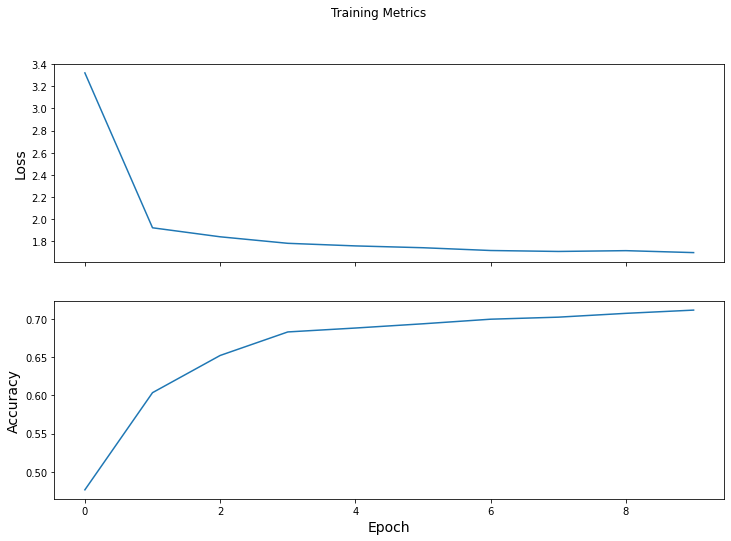

In [46]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [47]:
# Get the model prediction for an example input

idx = np.random.randint(0, 5000)

predictions = model(x_train[np.newaxis,idx])
predicted_label = np.argmax(predictions,axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[idx]]))
print("Other predictions: {}".format(np.round(np.sort(predictions)[0][::-1], 2)))

Prediction: acq
     Label: earn
Other predictions: [0.28 0.14 0.14 0.04 0.03 0.03 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]


In [48]:
preds = np.round(np.array(predictions)[0], 2)
indexes = list(np.argsort(np.array(predictions))[0][::-1])
' '.join([f'{class_names[idx]} {preds[idx]}' for idx in indexes])

'acq 0.2800000011920929 grain 0.14000000059604645 earn 0.14000000059604645 trade 0.03999999910593033 sugar 0.029999999329447746 money-fx 0.029999999329447746 ship 0.019999999552965164 oilseed 0.019999999552965164 coffee 0.019999999552965164 veg-oil 0.019999999552965164 cocoa 0.009999999776482582 livestock 0.009999999776482582 gold 0.009999999776482582 crude 0.009999999776482582 interest 0.009999999776482582 wheat 0.009999999776482582 copper 0.009999999776482582 alum 0.009999999776482582 iron-steel 0.009999999776482582 bop 0.009999999776482582 cotton 0.009999999776482582 money-supply 0.009999999776482582 nat-gas 0.009999999776482582 reserves 0.009999999776482582 pet-chem 0.009999999776482582 carcass 0.009999999776482582 orange 0.009999999776482582 rubber 0.009999999776482582 dlr 0.009999999776482582 tin 0.009999999776482582 jobs 0.009999999776482582 meal-feed 0.009999999776482582 gas 0.009999999776482582 ipi 0.009999999776482582 zinc 0.009999999776482582 cpi 0.009999999776482582 strateg

***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [50]:
# Initialize a new model

model = MyModel(64, 64, 46)

#### Redefine the grad function using the @tf.function decorator

In [51]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [52]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)


# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):

    # define the metrics we are going to use
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    for x, y in train_dataset:
        # optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # compute current loss
        epoch_loss_avg(loss_value)

        # compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print('Epoch: {:03d}, Loss: {:.3f}, Accuracy: {:.3f}'.format(epoch, 
                                                                 epoch_loss_avg.result(), 
                                                                 epoch_accuracy.result()))

    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch: 000, Loss: 2.421, Accuracy: 0.563
Epoch: 001, Loss: 1.924, Accuracy: 0.654
Epoch: 002, Loss: 1.837, Accuracy: 0.677
Epoch: 003, Loss: 1.780, Accuracy: 0.685
Epoch: 004, Loss: 1.756, Accuracy: 0.688
Epoch: 005, Loss: 1.734, Accuracy: 0.693
Epoch: 006, Loss: 1.715, Accuracy: 0.697
Epoch: 007, Loss: 1.708, Accuracy: 0.699
Epoch: 008, Loss: 1.710, Accuracy: 0.706
Epoch: 009, Loss: 1.685, Accuracy: 0.704
Duration :118.736


#### Print the autograph code

In [54]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

